# HW1 - Autoencoder

In [1]:
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
from torchvision import transforms
import torch.utils.data
import torchvision.datasets as dset
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt


# Set random seed for reproducibility
manualSeed = 1337
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  1337


In [2]:
# Parameters

data_root = './data'

workers = 1
ngpu = 1

image_size = 32 
nc = 3

dataset_fraction = 0.1
num_epochs = 50
batch_size = 64 

sgd_lr = 0.1
momentum = 0.9
adam_lr = 1e-3
beta1 = 0.5
weight_decay = 1e-8
std_dev = 0.01

use_adam = False
use_xavier = False
use_normalization = False

losses_interval = 10

Files already downloaded and verified
Files already downloaded and verified
tensor([6, 9, 1, 7, 5, 8, 6, 3])


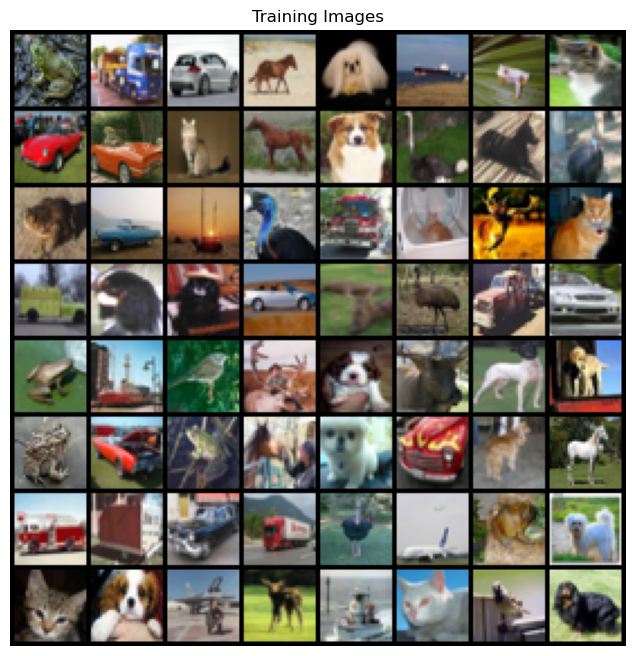

In [3]:
# Init data

if use_normalization:
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
else:
    transform = transforms.ToTensor()

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) 
                      else "mps:0" if torch.backends.mps.is_available() and ngpu > 0
                      else "cpu")

def get_subset(dataset, fraction):
    full_size = len(dataset)
    new_size = int(fraction * full_size)
    idxs = torch.randperm(full_size)[:new_size]
    return torch.utils.data.Subset(full_trainset, idxs)
    
full_trainset = dset.CIFAR10(root=data_root, train=True, download=True, transform=transform)
trainset = get_subset(full_trainset, dataset_fraction)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=workers)

full_testset = dset.CIFAR10(root=data_root, train=False, download=True, transform=transform)
testset = get_subset(full_testset, dataset_fraction)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=workers)

# Plot some training images
real_batch = next(iter(trainloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
print(real_batch[1].to(device)[:8].cpu())
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64].cpu(), padding=2, normalize=True),(1,2,0)))

In [ ]:
from sklearn.svm import SVC

def aggregate_from_loader(loader):
    features = []
    labels = []
    for batch_features, batch_labels in loader:
        # flatten feature tensors
        batch_features = batch_features.view(batch_features.shape[0], -1)

        # aggregate features and labels
        features.append(batch_features)
        labels.append(batch_labels)

    # concatenate features and labels from all batches
    features = torch.cat(features, dim=0)
    labels = torch.cat(labels, dim=0)
    return features, labels

train_features, train_labels = aggregate_from_loader(trainloader)
test_features, test_labels = aggregate_from_loader(testloader)

def get_scores_from_svc(kernel, train_features, train_labels):
    # Train SVM classifier with kernel
    svm = SVC(kernel=kernel)
    svm.fit(train_features, train_labels)
    train_acc = svm.score(train_features, train_labels)
    test_acc = svm.score(test_features, test_labels)
    return train_acc, test_acc

# Train SVM classifier with linear kernel
train_acc_linear, test_acc_linear = get_scores_from_svc('linear', train_features, train_labels)
# Train SVM classifier with RBF kernel
train_acc_rbf, test_acc_rbf = get_scores_from_svc('rbf', train_features, train_labels)

# Report train and test accuracies
print("Linear kernel:")
print("Train accuracy:", train_acc_linear)
print("Test accuracy:", test_acc_linear)
print()
print("RBF kernel:")
print("Train accuracy:", train_acc_rbf)
print("Test accuracy:", test_acc_rbf)

In [4]:
# Model
class CnnClassifier(nn.Module):
    def __init__(self, ngpu): 
        super().__init__()
        
        self.ngpu = ngpu
        
        self.conv = torch.nn.Sequential(
            # input is nc x 32 x 32
            nn.Conv2d(nc, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            # state size. 64 x 16 x 16
            nn.Conv2d(64, 16, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            # state size. 16 x 8 x 8
        )
        
        self.fc = torch.nn.Sequential(         
            nn.Linear(16 * 8 * 8, 784),
            nn.ReLU(inplace=True),
            nn.Linear(784, 10),
        )
        
    def forward(self, x):
        x = self.conv(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


In [5]:
# Init Model
model = CnnClassifier(ngpu).to(device)
print(model)

def init_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        if use_xavier:
            nn.init.xavier_uniform(m.weight)
        else:
            nn.init.normal_(m.weight, std=std_dev)
model.apply(init_weights)
loss_criterion = nn.CrossEntropyLoss()

if use_adam:
    optimizer = torch.optim.Adam(model.parameters(), lr=adam_lr, weight_decay=weight_decay)
else:
    optimizer = torch.optim.SGD(model.parameters(), lr=sgd_lr, momentum=momentum)


CnnClassifier(
  (conv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=1024, out_features=784, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=784, out_features=10, bias=True)
  )
)


In [6]:
# Training:
training_losses = []
training_losses_epochs = []
test_losses = []
loss_iters = 0
last_iters = 0
test_accuracies = []
train_accuracies = []

print("Starting Training Loop...")
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_class = 0
    total_labels = 0
    for i, data in enumerate(trainloader) :
        inputs, labels = [d.to(device) for d in data]
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = loss_criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_labels += labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct_class += (predicted == labels).sum().item()

        running_loss += loss.item()
        if i % losses_interval == losses_interval - 1:   
            mean_loss = running_loss / losses_interval
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {mean_loss:.3f}')
            training_losses.append(mean_loss)
            running_loss = 0.0
            loss_iters += 1
    
    training_losses_epochs.append(np.mean(training_losses[last_iters:loss_iters]))
    train_accuracy = correct_class / total_labels
    train_accuracies.append(train_accuracy)
    last_iters = loss_iters
    
    model.eval()
    correct_class = 0
    total_labels = 0
    total_loss = 0
    with torch.no_grad(): 
        for data in testloader:  
            inputs, labels = [d.to(device) for d in data]
            outputs = model(inputs)
            loss = loss_criterion(outputs, labels)
            total_loss += loss.item() * len(data)  # doing weighted average over batches
            _, predicted = torch.max(outputs.data, 1)
            total_labels += labels.size(0)
            correct_class += (predicted == labels).sum().item()
    test_loss = total_loss / len(testloader)
    test_losses.append(test_loss)  
    test_accuracy = correct_class / total_labels
    test_accuracies.append(test_accuracy)
    print('[%d/%d]\tTest Loss:\t%.4f' % (epoch + 1, num_epochs, test_loss))
    print(f"Train accuracy:\t{train_accuracy * 100:.1f}%")
    print(f"Test Accuracy:\t{test_accuracy * 100:.1f}%")


Starting Training Loop...
[1,    10] loss: 2.303
[1,    20] loss: 2.304
[1,    30] loss: 2.307
[1,    40] loss: 2.308
[1,    50] loss: 2.305
[1,    60] loss: 2.304
[1,    70] loss: 2.312
[1/50]	Test Loss:	4.6209
Train accuracy:	9.7%
Test Accuracy:	9.4%
[2,    10] loss: 2.305
[2,    20] loss: 2.301
[2,    30] loss: 2.310
[2,    40] loss: 2.301
[2,    50] loss: 2.297
[2,    60] loss: 2.232
[2,    70] loss: 2.227
[2/50]	Test Loss:	7.6695
Train accuracy:	13.3%
Test Accuracy:	13.1%
[3,    10] loss: 2.441
[3,    20] loss: 2.301
[3,    30] loss: 2.300
[3,    40] loss: 2.257
[3,    50] loss: 2.202
[3,    60] loss: 2.163
[3,    70] loss: 2.108
[3/50]	Test Loss:	4.2135
Train accuracy:	18.0%
Test Accuracy:	22.2%
[4,    10] loss: 2.055
[4,    20] loss: 2.077
[4,    30] loss: 1.985
[4,    40] loss: 2.065
[4,    50] loss: 2.059
[4,    60] loss: 1.964
[4,    70] loss: 2.058
[4/50]	Test Loss:	4.0588
Train accuracy:	26.7%
Test Accuracy:	27.0%
[5,    10] loss: 1.999
[5,    20] loss: 1.963
[5,    30] los

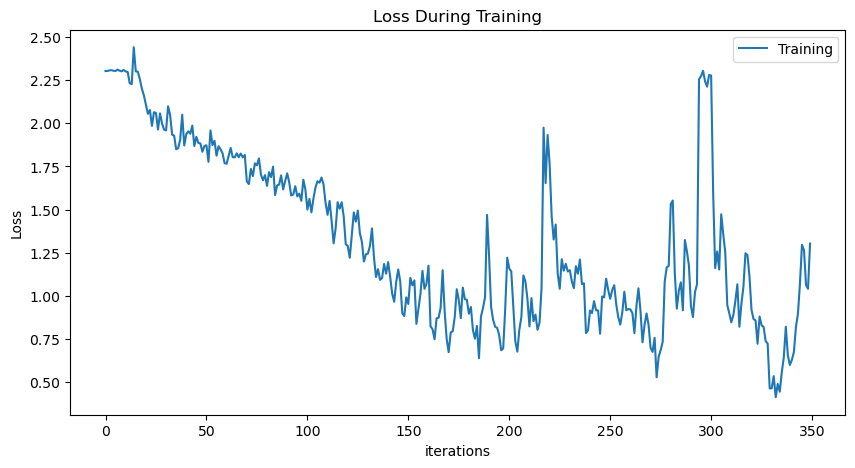

In [7]:
plt.figure(figsize=(10,5))
plt.title("Loss During Training")
plt.plot(training_losses, label='Training')
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

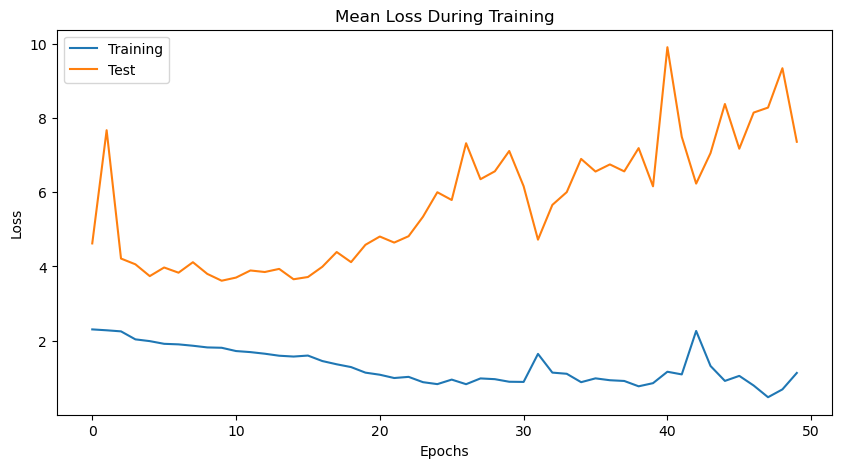

In [8]:
plt.figure(figsize=(10,5))
plt.plot(training_losses_epochs, label='Training')
plt.plot(test_losses, label="Test")
plt.title("Mean Loss During Training")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

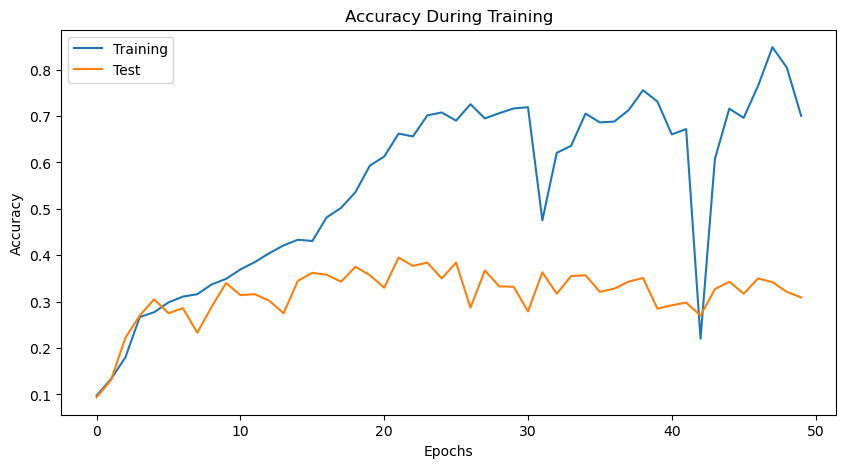

In [9]:
plt.figure(figsize=(10,5))
plt.plot(train_accuracies, label='Training')
plt.plot(test_accuracies, label="Test")
plt.title("Accuracy During Training")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()